In [15]:
import os
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr, linregress
from matplotlib.colors import TwoSlopeNorm

Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\캡스톤\EEG_arithmetic_task\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\캡스톤\EEG_arithmetic_task\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    6.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Applying baseline correction (mode: percent)
No baseline correction applied


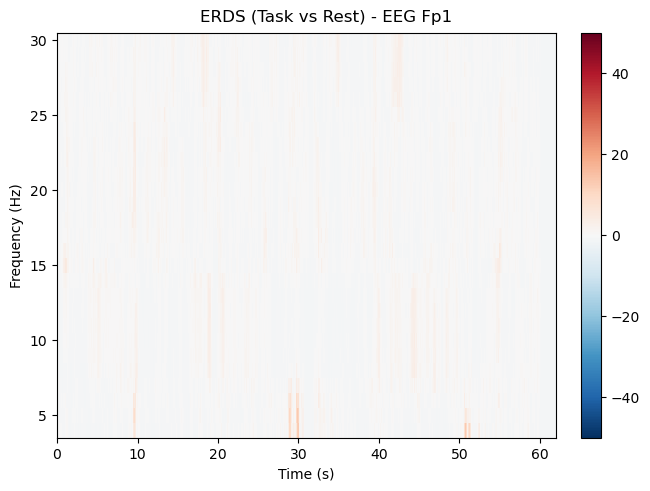

[<Figure size 640x480 with 2 Axes>]

In [16]:
# 파일 경로
subject = "00"
file_rest = f"./EEG_arithmetic_task/Subject{subject}_1.edf"
file_task = f"./EEG_arithmetic_task/Subject{subject}_2.edf"

# 데이터 로드 및 전처리
raw_rest = mne.io.read_raw_edf(file_rest, preload=True)
raw_task = mne.io.read_raw_edf(file_task, preload=True)

raw_rest.pick_types(eeg=True)
raw_task.pick_types(eeg=True)
raw_rest.rename_channels(lambda x: x.strip('.'))
raw_task.rename_channels(lambda x: x.strip('.'))
raw_task.pick_channels(raw_rest.ch_names)

# 각각 60초 epoch 생성
rest_epoch = mne.EpochsArray(raw_rest.get_data().reshape(1, *raw_rest.get_data().shape), 
                             mne.create_info(raw_rest.ch_names, raw_rest.info['sfreq'], ch_types='eeg'))
task_epoch = mne.EpochsArray(raw_task.get_data().reshape(1, *raw_task.get_data().shape), 
                             mne.create_info(raw_task.ch_names, raw_task.info['sfreq'], ch_types='eeg'))

# TFR 계산
freqs = np.arange(4, 31, 1)
n_cycles = freqs / 2.
tfr_rest = rest_epoch.compute_tfr(method="multitaper", freqs=freqs, n_cycles=n_cycles,
                                  use_fft=True, return_itc=False, average=True, decim=2)
tfr_task = task_epoch.compute_tfr(method="multitaper", freqs=freqs, n_cycles=n_cycles,
                                  use_fft=True, return_itc=False, average=True, decim=2)

# 베이스라인 적용 및 ERDS 계산 (% 변화)
tfr_task.apply_baseline(baseline=(0, 60), mode="percent")

# 시각화 (0번째 채널 기준)
vmin, vmax = -50, 50
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
tfr_task.plot([0], baseline=None, mode='percent', cmap="RdBu_r", cnorm=cnorm,
              title=f"ERDS (Task vs Rest) - {tfr_task.ch_names[0]}")